# **I. Preparation**

## A. Imports

In [ ]:
# Constants
PATH = '/content/drive/My Drive/Colab Notebooks/ocr_data_scientist/P6 Classification automatique/'
PATH_TEXT = PATH + 'Flipkart/'
FILE_TEXT = 'flipkart_com-ecommerce_sample_1050.csv'
PATH_PICTURE = PATH + 'Flipkart/Images/'

In [ ]:
!pip install -r PATH+requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'PATH+requirements.txt'


In [ ]:
import datetime as dt
import itertools
import math
import os
import re
import statistics as stat
import sys
import time

import cv2
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from collections import Counter
from difflib import SequenceMatcher
from importlib import reload

from google.colab.patches import cv2_imshow
from IPython.core.display import display,HTML
from keras.preprocessing.image import load_img, img_to_array
from scipy import ndimage as ndi

from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.text import TSNEVisualizer

In [ ]:
os.chdir(PATH)

In [ ]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/ocr_data_scientist/P6 Classification automatique'

In [ ]:
os.chdir(PATH)
sys.path.append(PATH)
import pca_functions
import kmeans_functions
import dbscan_functions
import perf_functions
reload(pca_functions)
reload(kmeans_functions)
reload(dbscan_functions)
reload(perf_functions)

<module 'perf_functions' from '/content/drive/My Drive/Colab Notebooks/ocr_data_scientist/P6 Classification automatique/perf_functions.py'>

In [ ]:
pd.options.display.precision = 5
sns.set_theme(style="darkgrid")

## B. Uploading

In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
def upload_csv(path, file, df_variable, df_name):
    df_variable = pd.read_csv(path + file, sep=',')
    df_variable.name = df_name
    return df_variable

In [ ]:
# CSV data extraction
merge_df = upload_csv(path=PATH,
                      file='merge_df.csv',
                      df_variable='merge_df',
                      df_name='Merge dataframe')

In [ ]:
merge_df.set_index('uniq_id', inplace=True)

In [ ]:
merge_df.shape

(1038, 9434)

In [ ]:
merge_df.head(3)

,crawl_timestamp,retail_price,discounted_price,fk_adv_prod,product_rating,overall_rating,cat_tree_depth,cat1_home_furnish,cat1_babi_care,cat1_watch,cat1_home_decor_festiv_need,cat1_kitchen_dine,cat1_beauti_person_care,cat1_comput,cat2_curtain_accessori,cat2_babi_bath_skin,cat2_bed_linen,cat2_wrist_watch,cat2_live_room_furnish,cat2_bath_linen,cat2_candl_fragranc,cat2_tablewar_cutleri,cat2_light,cat2_jmd_home_furnish,cat2_infant_wear,cat2_kripa_home_furnish,cat2_hair_care,cat2_coffe_mug,cat2_network_compon,cat2_tablet_accessori,cat2_cookwar,cat2_makeup,cat2_combo_kit,cat2_feed_nurs,cat2_babi_bed,cat2_kitchen_dine_linen,cat2_contain_bottl,cat2_consum_dispos,cat2_wall_decor_clock,cat2_tabl_decor_handicraft,...,desc_idea,desc_greas,desc_contamin,desc_pre,desc_discourag,desc_certain,desc_brick,desc_stucco,desc_concret,desc_sued,desc_squeez,desc_member,desc_deserv,desc_sweep,desc_options,desc_uberlyf,desc_polyvinyl,desc_film,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
uniq_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4,-63,1500.0,199.0,0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0
0096e89cc25a8b96fb9808716406fe94,-10,699.0,659.0,0,0.0,0.0,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00cbbc837d340fa163d11e169fbdb952,-177,1299.0,399.0,0,0.0,0.0,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


# **II. Feature Engineering**

## A. Log transformation

In [ ]:
merge_df.head(3)

,crawl_timestamp,retail_price,discounted_price,fk_adv_prod,product_rating,overall_rating,cat_tree_depth,cat1_home_furnish,cat1_babi_care,cat1_watch,cat1_home_decor_festiv_need,cat1_kitchen_dine,cat1_beauti_person_care,cat1_comput,cat2_curtain_accessori,cat2_babi_bath_skin,cat2_bed_linen,cat2_wrist_watch,cat2_live_room_furnish,cat2_bath_linen,cat2_candl_fragranc,cat2_tablewar_cutleri,cat2_light,cat2_jmd_home_furnish,cat2_infant_wear,cat2_kripa_home_furnish,cat2_hair_care,cat2_coffe_mug,cat2_network_compon,cat2_tablet_accessori,cat2_cookwar,cat2_makeup,cat2_combo_kit,cat2_feed_nurs,cat2_babi_bed,cat2_kitchen_dine_linen,cat2_contain_bottl,cat2_consum_dispos,cat2_wall_decor_clock,cat2_tabl_decor_handicraft,...,desc_idea,desc_greas,desc_contamin,desc_pre,desc_discourag,desc_certain,desc_brick,desc_stucco,desc_concret,desc_sued,desc_squeez,desc_member,desc_deserv,desc_sweep,desc_options,desc_uberlyf,desc_polyvinyl,desc_film,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
uniq_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4,-63,1500.0,199.0,0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0
0096e89cc25a8b96fb9808716406fe94,-10,699.0,659.0,0,0.0,0.0,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00cbbc837d340fa163d11e169fbdb952,-177,1299.0,399.0,0,0.0,0.0,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


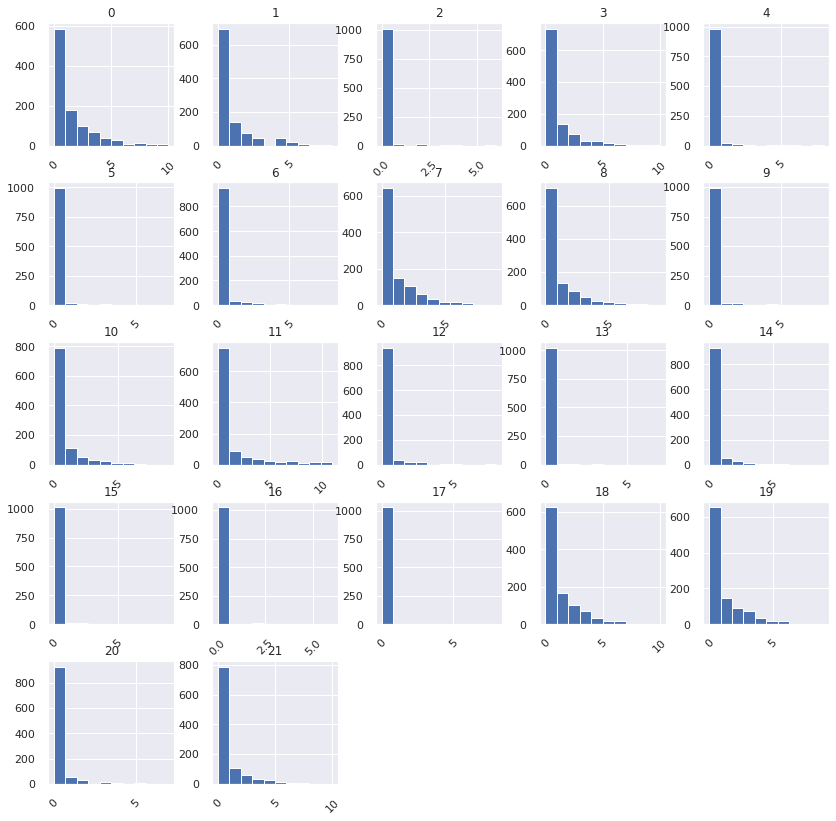

In [ ]:
descr_col = [str(element) for element in range(0, 22)]
merge_df[descr_col].hist(figsize=(14,14), xrot=45) 
plt.show()

In [ ]:
def log_transform(df, cols):
    '''Transform the given columns through logarithmic function.'''
    # Si certaines données sont négatives, transformer toutes les données
    # de manière à ce qu'elles soient toutes positives
    for column in cols:
        temp_list = []
        for element in df[column]:
            if element != 0:
                temp_list.append(math.log(element))
            else:
                temp_list.append(0)
        df['log(' + column + ')'] = temp_list
        df.drop(column, axis=1, inplace=True) 
    return df


if False:
    temp_df = pd.DataFrame(columns=descr_col)
    temp_df = log_transform(merge_df, descr_col)
    descr_col = ['log('+str(element)+')' for element in range(0, 22)]
    merge_df[descr_col].hist(figsize=(14,14), xrot=45) 
    plt.show()

In [ ]:
# No normal distribution appears. Log transformation is not relevant.

## B. Standardisation

In [ ]:
merge_df.head(3)

,crawl_timestamp,retail_price,discounted_price,fk_adv_prod,product_rating,overall_rating,cat_tree_depth,cat1_home_furnish,cat1_babi_care,cat1_watch,cat1_home_decor_festiv_need,cat1_kitchen_dine,cat1_beauti_person_care,cat1_comput,cat2_curtain_accessori,cat2_babi_bath_skin,cat2_bed_linen,cat2_wrist_watch,cat2_live_room_furnish,cat2_bath_linen,cat2_candl_fragranc,cat2_tablewar_cutleri,cat2_light,cat2_jmd_home_furnish,cat2_infant_wear,cat2_kripa_home_furnish,cat2_hair_care,cat2_coffe_mug,cat2_network_compon,cat2_tablet_accessori,cat2_cookwar,cat2_makeup,cat2_combo_kit,cat2_feed_nurs,cat2_babi_bed,cat2_kitchen_dine_linen,cat2_contain_bottl,cat2_consum_dispos,cat2_wall_decor_clock,cat2_tabl_decor_handicraft,...,desc_idea,desc_greas,desc_contamin,desc_pre,desc_discourag,desc_certain,desc_brick,desc_stucco,desc_concret,desc_sued,desc_squeez,desc_member,desc_deserv,desc_sweep,desc_options,desc_uberlyf,desc_polyvinyl,desc_film,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
uniq_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4,-63,1500.0,199.0,0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0
0096e89cc25a8b96fb9808716406fe94,-10,699.0,659.0,0,0.0,0.0,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00cbbc837d340fa163d11e169fbdb952,-177,1299.0,399.0,0,0.0,0.0,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


No feature has been considered to be relevantly transformed through
StandardScaler. We use then MinMaxScaler.

A relative small proportion of the features actually needs to be 
minmax scaled. The encoded columns are already within 0 and 1, so they do not need minmax scaler.

But, instead of filtering the features, it is more convenient to apply the minmax scaler on all columns.

In [ ]:
def min_max_scaler(df, cols):
    temp_df = df[cols]
    scaler = MinMaxScaler()
    temp_df = scaler.fit_transform(temp_df)
    temp_df = pd.DataFrame(temp_df,
                           columns=cols,
                           index=df.index)
    for column in cols:
        df[column] = temp_df[column]
    return df


merge_df = min_max_scaler(merge_df, list(merge_df.columns))

## C. PCA

In [ ]:
pca_class = pca_functions.PcaViz()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


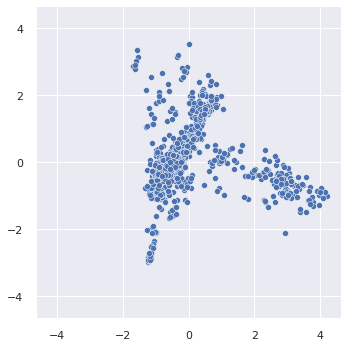

In [ ]:
if True:
    pca_class.draw_pca_n_dimensions(merge_df, 650)

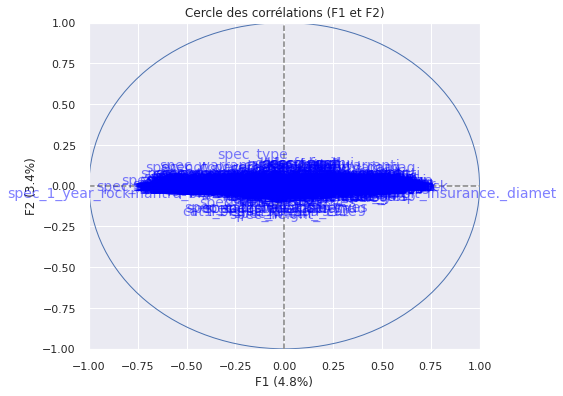

In [ ]:
if True:
    pca_class.draw_pca_circle(merge_df, 2)

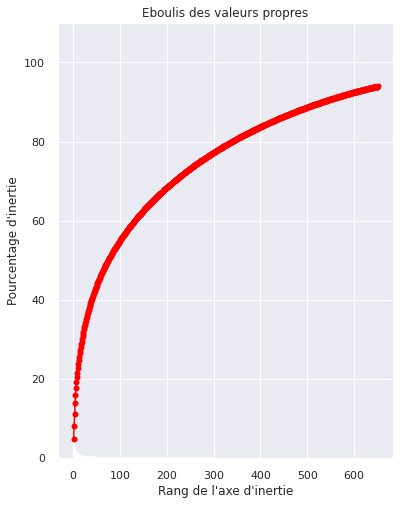

In [ ]:
if True:
    pca_class.display_scree_plot(data=merge_df,n_comp=650)
# Avec 650 composantes principales, on garde 95% de l'information.

# **III. Modelisation**

## A. Visualisations

In [ ]:
if False:
    embedded_df = TSNE(n_components=2,
                       perplexity=25,
                       early_exaggeration=5,
                       learning_rate=225).fit_transform(merge_pca_df)
    df_subset = pd.DataFrame(embedded_df[:, 0],
                             embedded_df[:, 1])
    sns.scatterplot(data=df_subset)

## B. Clustering

### 1 k-means

In [ ]:
def plot_dict(my_dict):
    '''Plot the values of a dict, according to their corresponding keys.'''
    keys = list(my_dict.keys())
    values = list(my_dict.values())
    plt.plot(keys, values)


def plot_several_lines(df, title, reverse=False):
    '''From the given dataframe of numbers, display the curbs.
    Abscissa and ordinates can be reversed.'''
    if reverse==True:
        for i, index in enumerate(df.index):
            x = list(df.columns)
            y = list(df.iloc[i])
            plt.plot(x, y, label=index)
        plt.xlabel('Number of principal components')
        plt.legend(title = "Numer of clusters")
    else:
        for i, column in enumerate(df.columns):
            x = list(df.index)
            y = list(df[column])
            plt.plot(x, y, label=column)
        plt.xlabel('Number of clusters')
        plt.legend(title = "Numer of principal components")
    plt.ylabel('Metrics value')
    plt.title(title)
    plt.show()

In [ ]:
merge_df.shape

(1038, 9434)

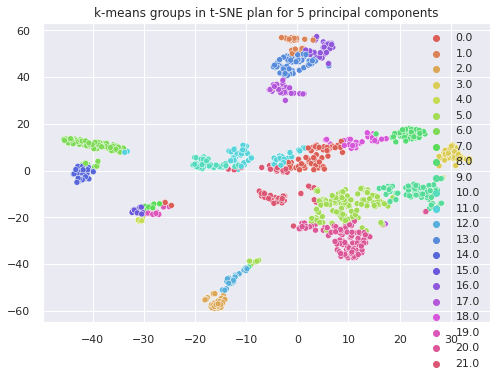

In [ ]:
if True:
    pca_class = pca_functions.PcaViz()
    kmeans_class = kmeans_functions.kmeans_op()
    kmeans_class.kmeans_in_tsne(pca_class.pca_dataframe(merge_df, 5), 22)

In [ ]:
if True:
    in_df, ch_df, db_df, sil_df = perf_functions.perf_n_clust(merge_df, [25, 22, 20, 15, 10, 8, 5])

25
22
20
15
10
8
5


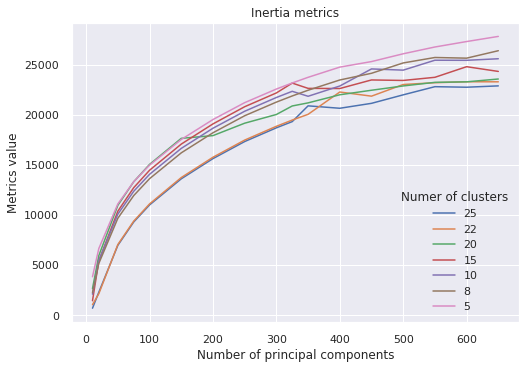

In [ ]:
if True:
    plot_several_lines(in_df,'Inertia metrics',reverse=True)

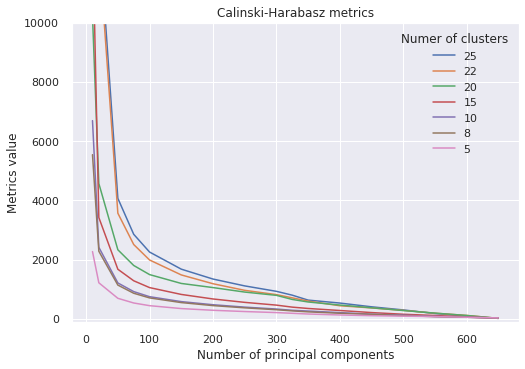

In [ ]:
if True:
    #plt.xlim(0, 20)
    plt.ylim((-100, 10000))
    plot_several_lines(ch_df,'Calinski-Harabasz metrics',reverse=True)

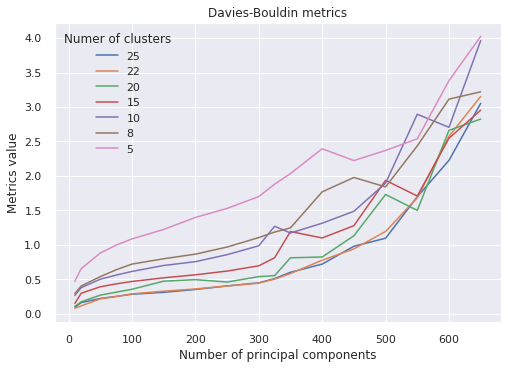

In [ ]:
if True:
    plot_several_lines(db_df,'Davies-Bouldin metrics',reverse=True)

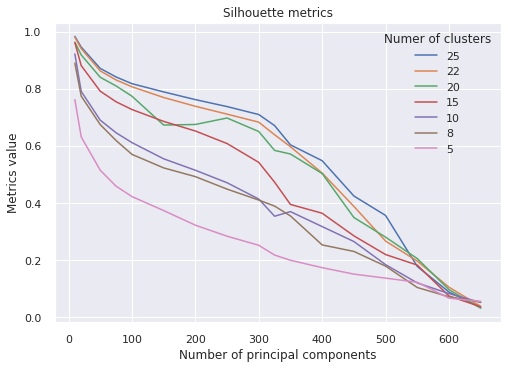

In [ ]:
if True:
    plot_several_lines(sil_df,'Silhouette metrics',reverse=True)

### 2 DBSCAN

In [ ]:
if False:
    calinksi_harabasz_dict = {}
    davies_bouldin_dict = {}
    pca_class = pca_functions.PcaViz()
    for n_pca in [200, 150, 125, 100, 75, 50, 20, 10, 8, 5, 4, 2]:
        dbscan_df, calinksi_harabasz_dict[n_pca], davies_bouldin_dict[n_pca] = dbscan_functions.dbscan_dataframe(
            pca_class.pca_dataframe(merge_df, n_pca))

In [ ]:
if False:
    plot_dict(calinksi_harabasz_dict)

In [ ]:
if False:
    plot_dict(davies_bouldin_dict)

In [ ]:
# Visualisation
pca_class = pca_functions.PcaViz()
dbscan_functions.dbscan_in_tsne(pca_class.pca_dataframe(merge_df, 4))

In [ ]:
def dbscan_pca_eval(df, n_pca_list):
    '''Compute the performances of DBSCAN in function of the number of principal
    components. Return a dataframe of the performances.'''
    scores_df = pd.DataFrame(
        columns=['Principal components',
                 'Noise points',
                 'Bigger group size',
                 'Average',
                 'Calinski-Harabasz',
                 'Davies-Bouldin',
                 'Silhouette'])
    scores_df.set_index('Principal components', inplace=True)
    for n_pca in n_pca_list:
        # noise points
        dbscan_df, ca_ha, da_bo, silhouette = dbscan_functions.dbscan_dataframe(
            pca_class.pca_dataframe(df, n_pca))
        labels_counter = Counter(dbscan_df['dbscan_labels'])
        group_dict = dict(labels_counter)
        #
        noise = group_dict[-1]
        del group_dict[-1]
        maximal_size = max(group_dict.values())
        average_size = stat.mean(group_dict.values())
        scores_df.loc[n_pca] = [noise, maximal_size, average_size,
                                ca_ha, da_bo, silhouette]
    return scores_df

In [ ]:
scores_df = dbscan_pca_eval(merge_df, list(range(2, 21)))

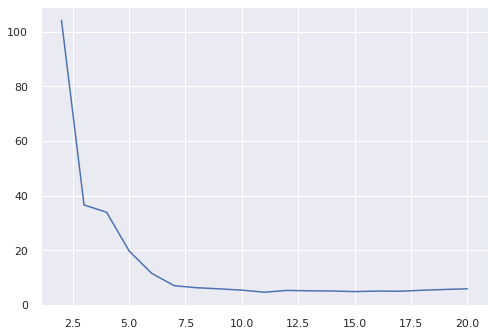

In [ ]:
plt.plot(scores_df.index,
         scores_df['Calinski-Harabasz'])

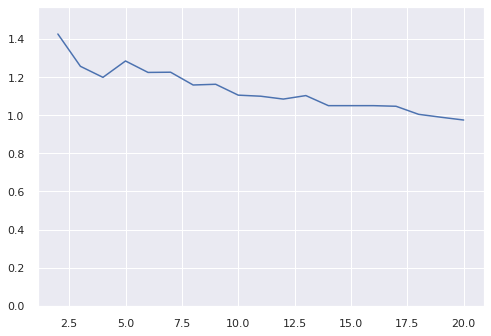

In [ ]:
plt.ylim((0, max(scores_df['Davies-Bouldin'])*1.1))
plt.plot(scores_df.index,
         scores_df['Davies-Bouldin'])

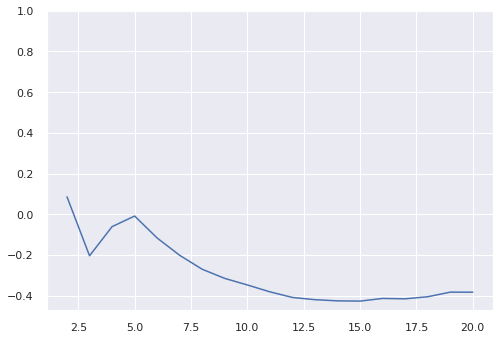

In [ ]:
plt.ylim((min(scores_df['Silhouette'])*1.1, 1))
plt.plot(scores_df.index,
         scores_df['Silhouette'])

# **IV. Optimisation**

## A. k-means

In [ ]:
def kmeans_optim(df, n_clust, n_init_list, max_iter_list, tol_list):
    scores_df = pd.DataFrame(columns=['index',
                                      'n_init',
                                      'max_iter',
                                      'tol',
                                      'inertia',
                                      'Calinski-Harabasz',
                                      'Davies-Bouldin',
                                      'Silhouette'])
    scores_df.set_index('index', inplace=True)
    i = 0
    for n_init in n_init_list:
        print('---------- \n', n_init)
        for max_iter in max_iter_list:
            for tolerance in tol_list:
                i += 1
                kmeans_model = KMeans(
                    n_clusters=n_clust,
                    n_init=n_init,
                    tol=tolerance)
                kmeans_model.fit(df)
                labels = kmeans_model.labels_
                inertia = kmeans_model.inertia_
                ca_ha = metrics.calinski_harabasz_score(df, labels)
                da_bo = metrics.davies_bouldin_score(df, labels)
                silhouette = metrics.silhouette_score(df, labels)
                scores_df.loc[i] = [n_init, max_iter, tolerancel, inertia, ca_ha, da_bo, silhouette]
    return scores_df

In [ ]:
scores_df = kmeans_optim(pca_class.pca_dataframe(merge_df, 300), 22,
    [10, 15, 20, 30],
    [300, 400, 500, 600],
    [0.0001, 0.0003, 0.0005, 0.0008, 0.001])

----------
10
----------
15
----------
20
----------
30


In [ ]:
def plot_metrics(df, column):
    df.sort_values(by=column, ascending=False, inplace=True)
    plt.ylim((0, max(df[column])*1.1))
    plt.plot(list(range(1, len(df)+1)),
            df[column])

In [ ]:
scores_df.head(3)

,n_init,max_iter,tol,inertia,Calinski-Harabasz,Davies-Bouldin,Silhouette
index,,,,,,,
1,10.0,300.0,0.0001,17351.99414,22.80052,2.51091,0.06847
2,10.0,300.0,0.0003,17520.85579,22.11449,2.39662,0.07043
3,10.0,300.0,0.0005,17349.22716,22.81187,2.52911,0.08001


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


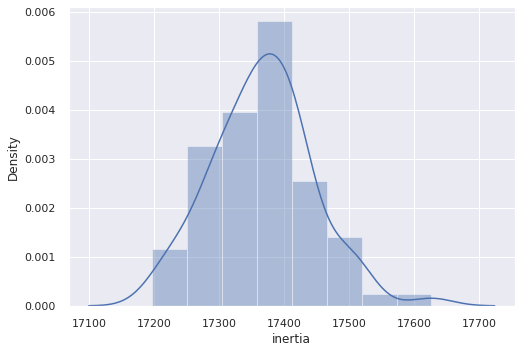

In [ ]:
sns.distplot(scores_df['inertia'], bins=8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


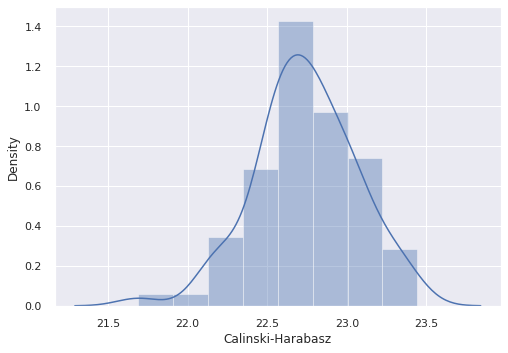

In [ ]:
sns.distplot(scores_df['Calinski-Harabasz'], bins=8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


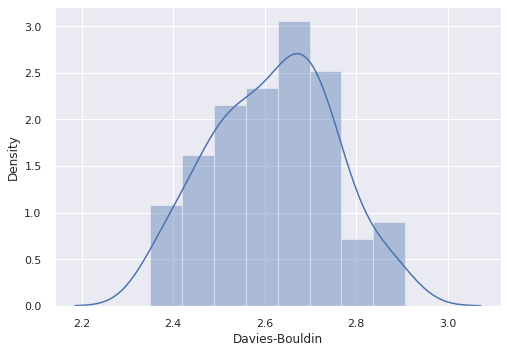

In [ ]:
sns.distplot(scores_df['Davies-Bouldin'],bins=8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


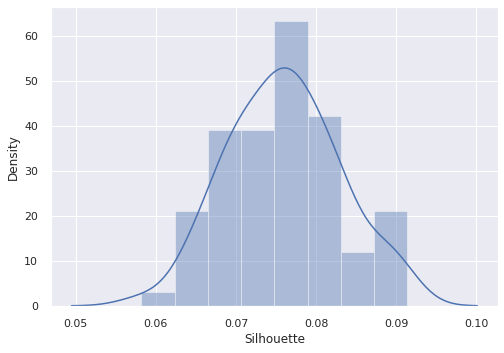

In [ ]:
sns.distplot(scores_df['Silhouette'], bins=8)

In [ ]:
study_df = scores_df[['n_init', 'Silhouette']].groupby(
    by='n_init').mean().sort_values(by='Silhouette', ascending=False)

In [ ]:
study_df = scores_df[['max_iter', 'Silhouette']].groupby(
    by='max_iter').mean().sort_values(by='Silhouette', ascending=False)
study_df

,Silhouette
max_iter,
400.0,0.07673
300.0,0.07615
500.0,0.07589
600.0,0.07515


In [ ]:
study_df = scores_df[['tol', 'Silhouette']].groupby(
    by='tol').mean().sort_values(by='Silhouette', ascending=False)
study_df

,Silhouette
tol,
0.0005,0.07712
0.0003,0.07702
0.0001,0.07641
0.0008,0.07583
0.0010,0.07353


## B. DBSCAN

In [ ]:
def dbscan_optim(df, eps_list, min_samples_list, leaf_size_list):
    scores_df = pd.DataFrame(columns=['index',
                                      'eps',
                                      'min_samples',
                                      'leaf_size',
                                      'Calinski-Harabasz',
                                      'Davies-Bouldin',
                                      'Silhouette'])
    scores_df.set_index('index', inplace=True)
    i = 0
    for eps in eps_list:
        print('---------- \n', eps)
        for min_samples in min_samples_list:
            for leaf_size in leaf_size_list:
                i += 1
                dbscan = DBSCAN(eps=eps,
                                min_samples=min_samples,
                                leaf_size=leaf_size)
                dbscan.fit(df)
                labels = dbscan.labels_
                try:
                    ca_ha = metrics.calinski_harabasz_score(df, labels)
                except ValueError:
                    ca_ha = np.nan
                try:
                    da_bo = metrics.davies_bouldin_score(df, labels)
                except ValueError:
                    da_bo = np.nan
                try:
                    silhouette = metrics.silhouette_score(df, labels)
                except ValueError:
                    silhouette = np.nan
                scores_df.loc[i] = [eps, min_samples, leaf_size, ca_ha, da_bo, silhouette]
    return scores_df

In [ ]:
dbscan_scores_df = dbscan_optim(pca_class.pca_dataframe(merge_df, 300),
                                [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                                [2, 3, 4, 5],
                                [10, 20, 30])

----------
0.02
----------
0.05
----------
0.1
----------
0.2
----------
0.3
----------
0.4
----------
0.5
----------
0.6
----------
0.7


In [ ]:
study_df = dbscan_scores_df[['eps', 'Silhouette']].groupby(
    by='eps').mean().sort_values(by='Silhouette', ascending=False)
study_df

,Silhouette
eps,
0.02,0.38187
0.05,0.38187
0.10,0.38187
0.20,0.02444
0.40,-0.05669
0.50,-0.06023
0.70,-0.09566
0.60,-0.09597
0.30,-0.20903


In [ ]:
study_df = dbscan_scores_df[['min_samples', 'Silhouette']].groupby(
    by='min_samples').mean().sort_values(by='Silhouette', ascending=False)
study_df

,Silhouette
min_samples,
2.0,0.01601
4.0,0.01519
5.0,0.00897
3.0,-0.09477


In [ ]:
study_df = dbscan_scores_df[['leaf_size', 'Silhouette']].groupby(
    by='leaf_size').mean().sort_values(by='Silhouette', ascending=False)
study_df

,Silhouette
leaf_size,
10.0,-0.00822
20.0,-0.00822
30.0,-0.00822


# **V. Verification**

## A. k-means

In [ ]:
# Apply PCA to original dataframe
pca_class = pca_functions.PcaViz()
pca_300_df = pca_class.pca_dataframe(merge_df, 300)
# Creation of dataframe with k-means labels
kmean_class = kmeans_functions.kmeans_op()
kmeans_df, a,b,c,d = kmeans_class.kmeans_dataframe(my_dataframe=pca_300_df,
                                                   n_clust=22)

In [ ]:
kmeans_df[kmeans_df['k-means_labels']==9]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,k-means_labels
uniq_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0991e8d8f884003ab18890971191085d,-1.11781,-0.42256,-1.11458,0.13855,0.73798,-0.68559,0.29649,0.12848,-0.04065,-1.30667,-0.01205,0.25332,-0.44249,0.69856,-1.07784,-0.12035,0.01226,-0.21045,-0.05979,0.30264,0.66755,0.18307,-0.35911,0.14817,0.02107,0.59367,0.02105,0.61351,-0.24203,-0.08620,-0.28000,-0.07607,-0.21809,-0.03526,-0.16936,0.13472,0.01578,-0.15266,0.20538,-0.23484,...,-0.22663,-0.13606,-0.16816,-0.06952,-0.02004,-0.01546,-0.03830,0.24905,-0.29953,0.13530,0.03561,-0.21731,-0.26190,0.01925,-0.24946,0.13910,0.15100,-0.34661,-0.14391,-0.25363,0.16954,-0.13645,-0.06418,-0.10177,-0.11571,-0.20966,0.07851,0.09311,0.08426,-0.12035,0.03973,0.02790,-0.21513,-0.01952,-0.01088,-0.01337,0.29448,-0.00538,0.03489,9
0bff0eda7a6677dc1acb0477a1f7a121,-1.07043,-0.29019,-1.20140,0.04315,0.72482,-0.70147,0.43293,0.05923,-0.05492,-1.28279,0.01760,0.33658,-0.49289,0.52845,-0.84281,-0.16565,-0.25026,0.03821,0.14050,-0.03684,0.53848,0.21832,-0.18514,-0.07827,0.12196,0.12461,-0.09715,0.19560,0.14503,-0.36879,-0.36691,-0.07811,-0.16778,-0.13708,-0.21107,-0.01735,-0.21513,-0.07610,-0.03821,0.04231,...,0.05560,0.16672,-0.15966,-0.00520,-0.26358,-0.20546,0.11557,0.02431,0.22004,0.07378,-0.04154,0.05674,-0.05476,-0.24863,-0.11688,-0.02282,-0.18367,-0.06095,-0.05257,0.36183,-0.24233,-0.14173,0.02149,0.27408,-0.51013,0.15324,0.09832,0.08601,0.05815,0.30889,-0.13872,-0.26866,0.10675,-0.00896,-0.10049,-0.26687,-0.16447,-0.13115,-0.12344,9
141d2b743c477043041faddf9233c8ad,-0.97146,-0.24123,-1.39980,0.04679,-0.05124,-0.92038,0.48193,0.05389,-0.24320,-1.19229,-0.14308,0.40455,-0.62067,0.49105,-0.48497,0.04923,-0.15303,0.16250,0.10484,-0.20316,-0.14995,0.14942,0.13740,-0.03286,-0.03071,0.18489,0.10549,0.08632,0.07235,-0.22235,-0.34899,-0.20841,-0.22393,-0.17129,0.02608,0.06067,-0.04486,-0.03825,0.03105,0.02025,...,-0.05515,0.15223,-0.07777,0.01463,0.05651,0.12924,-0.07766,-0.04360,0.03101,0.15273,-0.05678,-0.10445,-0.05755,-0.23240,-0.06638,-0.03027,-0.08811,0.05784,0.09012,-0.18421,0.00538,-0.09297,0.12266,-0.09339,0.01374,0.06155,0.00832,0.06118,-0.03597,0.02447,-0.02616,0.10245,0.04790,-0.13693,0.14153,-0.04434,0.02963,-0.00238,-0.09664,9
23b0bdd337f7d1b4b70ad13726a122ab,-1.18453,0.06769,-1.23052,0.60673,0.62239,-0.36575,0.36901,-0.25244,-0.17316,-1.57425,0.04867,0.42323,-0.50626,0.73962,-0.79629,-0.09816,-0.16648,0.51209,0.40047,-0.36706,0.34059,0.68476,-0.43583,-0.06563,-0.17879,0.08738,-0.19662,0.49499,0.40194,-0.59757,-0.08799,-0.34302,-0.92172,1.22202,0.46142,-0.62045,-1.47508,0.80045,-0.19856,0.41405,...,0.03238,0.16647,0.21016,-0.26918,-0.11364,0.12663,0.03516,-0.05374,0.09681,-0.01377,-0.08480,-0.24416,0.02751,0.13873,0.13556,-0.16732,0.06701,-0.05428,-0.14939,0.04360,-0.10899,-0.17304,0.06646,0.17415,0.06596,-0.03765,-0.15837,-0.07434,0.00282,-0.04944,-0.11942,0.04081,-0.13773,0.05682,-0.03668,0.16332,0.43006,-0.00471,-0.11472,9
25ce025c38c55f28fd0ea3bb0200df79,-1.03067,-0.28226,-1.28825,0.04676,0.31701,-0.75266,0.38713,0.07739,-0.17139,-1.07798,-0.17779,0.34173,-0.57238,0.42596,-0.59264,-0.07453,-0.21752,0.03581,0.13076,-0.13302,0.05171,0.23654,-0.02446,-0.17309,-0.06939,0.10731,-0.09662,0.15650,0.02424,-0.21487,-0.32605,0.11565,0.01080,-0.13479,-0.07709,0.27746,-0.13111,0.04916,0.05397,0.03528,...,-0.03327,-0.04367,-0.13233,0.01456,-0.08659,0.02243,0.10783,0.12155,-0.05042,-0.34201,-0.04096,-0.04419,-0.08349,0.42437,-0.36908,0.09011,0.05007,-0.27710,0.07170,0.18658,0.14286,0.01256,-0.18808,0.18592,-0.12037,0.22013,0.09809,0.14175,0.07277,-0.28735,0.19111,0.14042,-0.01407,0.02263,-0.23054,0.10051,-0.00028,0.20479,-0.15525,9
...,...,...,...,...,...,...,...,...,...,...,...,...,.

## B. DBSCAN

### 1. Manual visualisation

In [ ]:
def dbscan_results(df):
    dbscan_clustering = DBSCAN(eps=0.1).fit(df)
    labels = dbscan_clustering.labels_
    if len(Counter(labels)) == 1:
        return print('Only noise points')
    df['dbscan_labels'] = labels
    noise_points = len(df[df['dbscan_labels']==-1])
    df = df[df['dbscan_labels']!=-1]
    return df.sort_values(by='dbscan_labels'), noise_points

In [ ]:
dbscan_df, noise_points = dbscan_results(pca_class.pca_dataframe(merge_df, 5))

In [ ]:
dbscan_df[dbscan_df['dbscan_labels']==3]

,0,1,2,3,4,dbscan_labels
uniq_id,,,,,,
6da53319cc12c9729881f5478ff67223,-1.09266,-2.56695,2.06745,0.66446,-1.34320,3
3c4ca34c50a5437a1bcc42b72fc1351f,-1.07457,-2.55974,2.07756,0.66696,-1.34951,3
ea16e13a7cf16d8665d1bc44738dfa88,-1.08422,-2.56800,2.07265,0.66638,-1.34666,3
6efd5d260667b94f04edbbd18bb300b9,-1.07371,-2.55752,2.07395,0.66605,-1.34725,3
1afa5f2c3c9b4b43def6dc2e695d2c87,-1.07829,-2.55810,2.08137,0.66409,-1.35255,3


### 2. Automatic visualisation

In [ ]:
n_pca = 22
dbscan_df, ch, db = dbscan_functions.dbscan_dataframe(pca_class.pca_dataframe(merge_df, n_pca))

In [ ]:
import glob
import random
import base64

from PIL import Image
from io import BytesIO

In [ ]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [ ]:
HTML(path_to_image_html(PATH_PICTURE+'9412b6fe7b97e405def91f24f064c547.jpg'))

In [ ]:
img = Image.open(PATH_PICTURE + '9412b6fe7b97e405def91f24f064c547' + '.jpg')

In [ ]:
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'
pd.set_option('display.max_colwidth', None)


# Creation of empty dataframe
output_df = pd.DataFrame(index=range(0, 3),
                         columns=['Group'+str(i) for i in range(0, n_clust)])

# Clean and sort the list of labels
labels_list = list(dbscan_df['dbscan_labels'].unique())
labels_list.remove(-1)
labels_list.sort()

PATH_PICTURE_PC = 'C:/Users/benoi/Documents/20.3 Informatique/Data Science/0_process/P6 Classifiez des biens de consommation/Flipkart/Images/'
PATH_PICTURE_DRIVE = '../Flipkart/Images/'

for label in labels_list:
    images = list(dbscan_df[dbscan_df['dbscan_labels']==label].head(3).index)
    images = [PATH+image+'.jpg' for image in images]
    output_df['Group'+str(label)] = images

# Create the dictionary to be passed as formatters
format_dict = {}
for image_col in list(output_df.columns):
    format_dict[image_col] = path_to_image_html

display(HTML(output_df.to_html(escape=False,
                               formatters=format_dict)))